# Comparing M6A ML models
Currently, we have trained logistic regression, xgboost and CNN models. This notebook compares XGBoost and CNN models. Alan Min (alantmin@uw.edu) has the logistic regression code as well the baselines. 

In [1]:
# Get all the requisite imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import requests
import io
import xgboost as xgb 
from m6a_calling import M6ANet

from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             balanced_accuracy_score,
                             matthews_corrcoef,
                             roc_auc_score,
                             average_precision_score,
                             roc_curve,
                             precision_recall_curve
                             )

# Compare XGBoost and CNN models on aggregate subreads data

## Load the test_more_large data (aggregate subreads)

In [3]:
data_path = "../data/m6A_test_more_large.npz"

test_data = np.load(data_path, allow_pickle=True)

# Get the dictionary from the containing relevant data
test_data = test_data['save_data_dict'][()]

# Load test features and labels
X_test = np.array(test_data['X_test'])
y_test = np.array(test_data['y_test'])
test_subreads = np.array(test_data['test_subread_counts'])

### Run the CNN model prediction

In [4]:
m6a_model = torch.load("models/m6ANet_more_large.3.best.torch", map_location=torch.device('cpu'))

X_test = torch.Tensor(X_test)
test_pred_cnn = m6a_model.predict(X_test, device='cpu').detach().numpy()

### Run the XGBoost model prediction

In [6]:
bst2 = xgb.Booster({'nthread': 4})  # init model
bst2.load_model('models/xgboost.lg.strandfix.json')  # load data

# Flatten our data as xgboost takes 2D data and our data is 3D
X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

dtest = xgb.DMatrix(X_test_2d)
test_pred_xgb = bst2.predict(dtest)

### Get the AUROC for xgboost and CNN model

We are plotting ROC and PR curves for the CNN model first. 

read: 1
AUC-ROC CNN: 0.987
read: 2
AUC-ROC CNN: 0.991
read: 3
AUC-ROC CNN: 0.994
read: 4
AUC-ROC CNN: 0.997
read: 5
AUC-ROC CNN: 0.998
read: 6
AUC-ROC CNN: 0.999
read: 1
AU-PR CNN: 0.9080084617798796
read: 2
AU-PR CNN: 0.9304745864464955
read: 3
AU-PR CNN: 0.9539590512824527
read: 4
AU-PR CNN: 0.9733544006302189
read: 5
AU-PR CNN: 0.9845236476428836
read: 6
AU-PR CNN: 0.9893969465736916


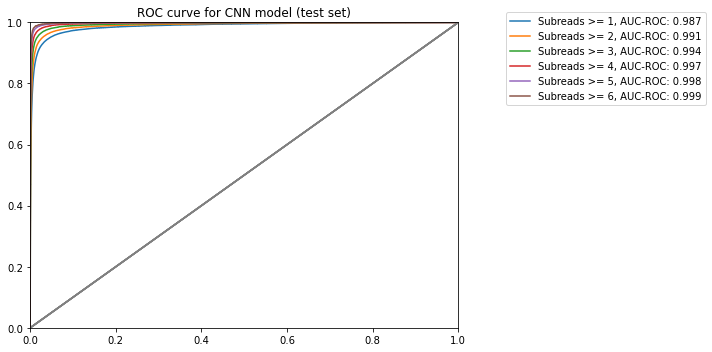

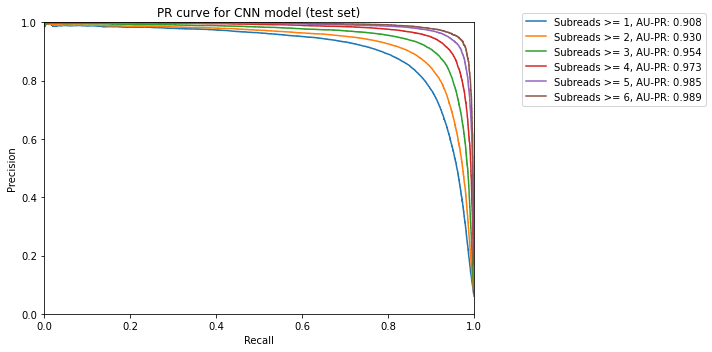

In [7]:
# Get the ROC curves for different number of subreads.
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(test_subreads >= read)[0]
    y_pred = test_pred_cnn[subread_thr, 0]
    y_obs = y_test[subread_thr, 0]

    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    
    print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.03f}")
    plt.plot(fpr, tpr, label=f"Subreads >= {read}, AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.axline([0,0], slope=1, c="gray")
    #plt.text(.6, .2, f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}") 
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("ROC curve for CNN model (test set)")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/roc_cnn_test.png")
    plt.plot()

# Get the PR curves for different number of subreads. 
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(test_subreads >= read)[0]
    y_pred = test_pred_cnn[subread_thr, 0]
    y_obs = y_test[subread_thr, 0]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    precision, recall, thresholds = metrics.precision_recall_curve(y_obs, y_pred, pos_label=1)
    print(f"AU-PR CNN: {metrics.average_precision_score(y_obs, y_pred)}")

    plt.plot(recall, precision, label=f"Subreads >= {read}, AU-PR: {metrics.average_precision_score(y_obs, y_pred):.03f}")
    #plt.axline([0,0], slope=1, c="gray")

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("PR curve for CNN model (test set)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/pr_cnn_test.png")
    plt.plot()

We are plotting ROC and PR curves for the xgBoost model now. 

read: 1
AUC-ROC: 0.989
read: 2
AUC-ROC: 0.992
read: 3
AUC-ROC: 0.995
read: 4
AUC-ROC: 0.997
read: 5
AUC-ROC: 0.998
read: 6
AUC-ROC: 0.999
read: 1
AU-PR XGBoost: 0.922
read: 2
AU-PR XGBoost: 0.939
read: 3
AU-PR XGBoost: 0.958
read: 4
AU-PR XGBoost: 0.975
read: 5
AU-PR XGBoost: 0.985
read: 6
AU-PR XGBoost: 0.989


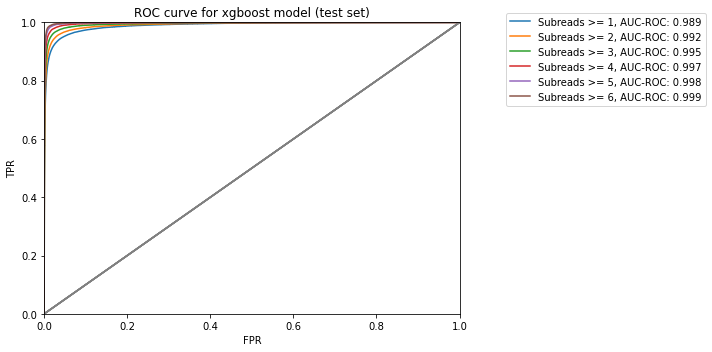

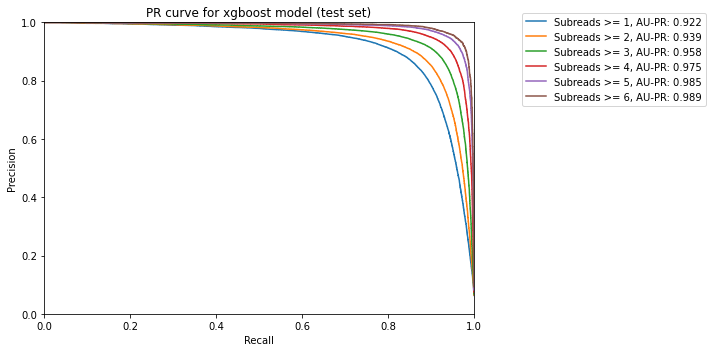

In [11]:
# Get the ROC curves for different number of subreads.
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(test_subreads >= read)[0]
    y_pred = test_pred_xgb[subread_thr]
    y_obs = y_test[subread_thr, 0]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    
    print(f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.plot(fpr, tpr, label=f"Subreads >= {read}, AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.axline([0,0], slope=1, c="gray")

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("ROC curve for xgboost model (test set)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/roc_xgboost_test.png")
    plt.plot()
    
# Get the PR curves for different number of subreads.   
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(test_subreads >= read)[0]
    y_pred = test_pred_xgb[subread_thr]
    y_obs = y_test[subread_thr, 0]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    precision, recall, thresholds = metrics.precision_recall_curve(y_obs, y_pred, pos_label=1)
    print(f"AU-PR XGBoost: {metrics.average_precision_score(y_obs, y_pred):.03f}")

    plt.plot(recall, precision, label=f"Subreads >= {read}, AU-PR: {metrics.average_precision_score(y_obs, y_pred):.03f}")
    #plt.axline([0,0], slope=1, c="gray")

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("PR curve for xgboost model (test set)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/pr_xgboost_test.png")
    plt.plot()

### Make predictions using the XGBoost and CNN model for PS00075_1 independent test data

CNN AUC-ROC: 0.982
CNN AU-PR: 0.822
read: 1
AUC-ROC CNN: 0.982
read: 2
AUC-ROC CNN: 0.987
read: 3
AUC-ROC CNN: 0.991
read: 4
AUC-ROC CNN: 0.995
read: 5
AUC-ROC CNN: 0.997
read: 6
AUC-ROC CNN: 0.998
read: 1
AU-PR CNN: 0.8221764499831903
read: 2
AU-PR CNN: 0.853048804595147
read: 3
AU-PR CNN: 0.8906072007946805
read: 4
AU-PR CNN: 0.9299478438324269
read: 5
AU-PR CNN: 0.9517129600385517
read: 6
AU-PR CNN: 0.9649287297086907
XGBoost AUC-ROC: 0.985
XGBoost AU-PR: 0.853
read: 1
AUC-ROC XGBoost: 0.985
read: 2
AUC-ROC XGBoost: 0.988
read: 3
AUC-ROC XGBoost: 0.992
read: 4
AUC-ROC XGBoost: 0.996
read: 5
AUC-ROC XGBoost: 0.997
read: 6
AUC-ROC XGBoost: 0.998
read: 1
AU-PR XGBoost: 0.8528300907169303
read: 2
AU-PR XGBoost: 0.8746718968041802
read: 3
AU-PR XGBoost: 0.9052598281304632
read: 4
AU-PR XGBoost: 0.9378498097952781
read: 5
AU-PR XGBoost: 0.95682398093547
read: 6
AU-PR XGBoost: 0.96814230914694


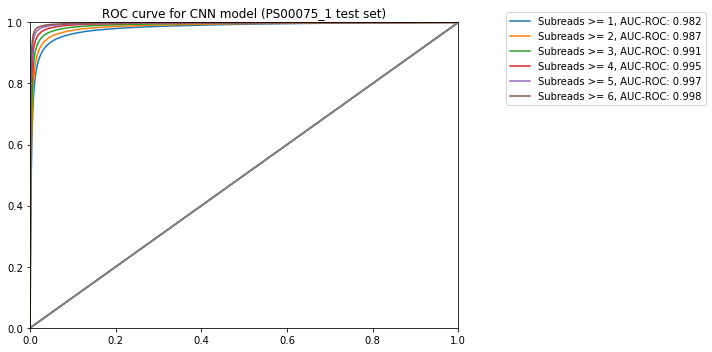

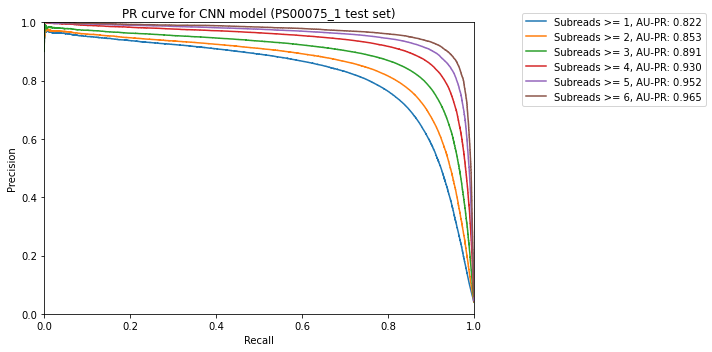

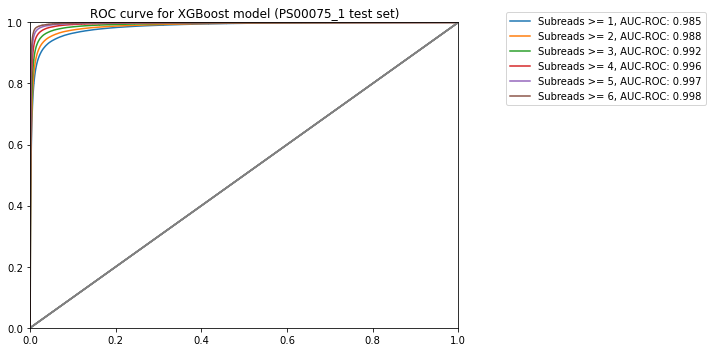

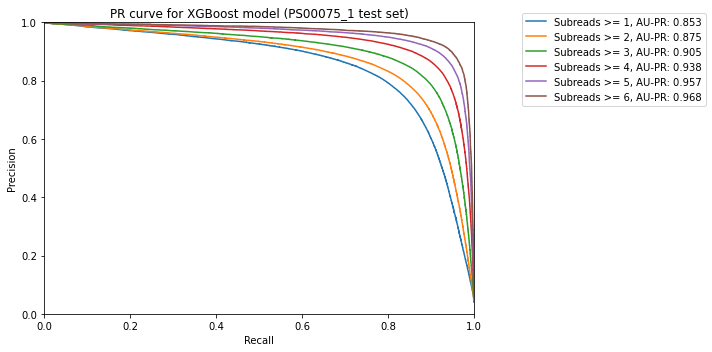

In [12]:
# Load the Test 
train_ipd_matched_path = "../data/PS00075_1_PredictAll_m6A_train.npz"
test_ipd_matched_path = "../data/PS00075_1_PredictAll_m6A_test.npz"

train_val_data = np.load(train_ipd_matched_path, allow_pickle=True)

# Get the dictionary from the containing relevant data
train_val_data = train_val_data['save_data_dict'][()]

# Load training and validation features and labels
X_train = train_val_data['X_train']
y_train = train_val_data['y_train']
X_val = train_val_data['X_val']
y_val = train_val_data['y_val']


test_data = np.load(test_ipd_matched_path, allow_pickle=True)
test_data = test_data['save_data_dict'][()]

X_test = test_data['X_test']
y_test = test_data['y_test']

X_all = np.concatenate((X_train, X_val, X_test))
y_all = np.concatenate((y_train, y_val, y_test))

ccs_all = np.concatenate((train_val_data['train_final_ccss'], train_val_data['val_final_ccss'], test_data['test_final_ccss']))
subreads_all = np.concatenate((train_val_data['train_subread_counts'], train_val_data['val_subread_counts'], test_data['test_subread_counts']))
m6a_calls_pos_all = np.concatenate((train_val_data['train_final_m6a_call_positions'], train_val_data['val_final_m6a_call_positions'], test_data['test_final_m6a_call_positions']))


#CNN model
m6a_model = torch.load("models/m6ANet_more_large.3.best.torch", map_location=torch.device('cpu'))

X_all_tor = torch.Tensor(X_all)
pred_cnn = m6a_model.predict(X_all_tor, device='cpu').detach().numpy()

fpr, tpr, thresholds = metrics.roc_curve(y_all[:, 0], pred_cnn[:, 0], pos_label=1)
print(f"CNN AUC-ROC: {metrics.auc(fpr, tpr):.03f}")

precision, recall, thresholds = metrics.precision_recall_curve(y_all[:, 0], pred_cnn[:, 0], pos_label=1)
print(f"CNN AU-PR: {metrics.average_precision_score(y_all[:, 0], pred_cnn[:, 0]):.03f}")

# Plot ROC curve for the CNN model
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(subreads_all >= read)[0]
    y_pred = pred_cnn[subread_thr, 0]
    y_obs = y_all[subread_thr, 0]

    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    
    print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.03f}")
    plt.plot(fpr, tpr, label=f"Subreads >= {read}, AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.axline([0,0], slope=1, c="gray")
    #plt.text(.6, .2, f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}") 
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("ROC curve for CNN model (PS00075_1 test set)")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/roc_cnn_indtest.png")
    plt.plot()
    
# Plot PR curve for the CNN model
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(subreads_all >= read)[0]
    y_pred = pred_cnn[subread_thr, 0]
    y_obs = y_all[subread_thr, 0]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    precision, recall, thresholds = metrics.precision_recall_curve(y_obs, y_pred, pos_label=1)
    print(f"AU-PR CNN: {metrics.average_precision_score(y_obs, y_pred)}")

    plt.plot(recall, precision, label=f"Subreads >= {read}, AU-PR: {metrics.average_precision_score(y_obs, y_pred):.03f}")
    #plt.axline([0,0], slope=1, c="gray")

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("PR curve for CNN model (PS00075_1 test set)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/pr_cnn_indtest.png")
    plt.plot()

# XGBoost model
bst2 = xgb.Booster({'nthread': 4})  # init model
bst2.load_model('models/xgboost.lg.strandfix.json')  # load data

X_all_2d = X_all.reshape(X_all.shape[0], X_all.shape[1] * X_all.shape[2])

dall = xgb.DMatrix(X_all_2d)
pred_xgboost = bst2.predict(dall)

fpr, tpr, thresholds = metrics.roc_curve(y_all[:, 0], pred_xgboost, pos_label=1)
print(f"XGBoost AUC-ROC: {metrics.auc(fpr, tpr):.03f}")

precision, recall, thresholds = metrics.precision_recall_curve(y_all[:, 0], pred_xgboost, pos_label=1)
print(f"XGBoost AU-PR: {metrics.average_precision_score(y_all[:, 0], pred_xgboost):.03f}")

# ROC curve for the XGBoost model
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(subreads_all >= read)[0]
    y_pred = pred_xgboost[subread_thr]
    y_obs = y_all[subread_thr, 0]

    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    
    print(f"AUC-ROC XGBoost: {metrics.auc(fpr, tpr):.03f}")
    plt.plot(fpr, tpr, label=f"Subreads >= {read}, AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.axline([0,0], slope=1, c="gray")
    #plt.text(.6, .2, f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}") 
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("ROC curve for XGBoost model (PS00075_1 test set)")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/roc_xgboost_indtest.png")
    plt.plot()

# PR curve for the XGBoost model
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(subreads_all >= read)[0]
    y_pred = pred_xgboost[subread_thr]
    y_obs = y_all[subread_thr, 0]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    precision, recall, thresholds = metrics.precision_recall_curve(y_obs, y_pred, pos_label=1)
    print(f"AU-PR XGBoost: {metrics.average_precision_score(y_obs, y_pred)}")

    plt.plot(recall, precision, label=f"Subreads >= {read}, AU-PR: {metrics.average_precision_score(y_obs, y_pred):.03f}")
    #plt.axline([0,0], slope=1, c="gray")

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("PR curve for XGBoost model (PS00075_1 test set)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig("figures/pr_xgboost_indtest.png")
    plt.plot()

# Save this data for future reference
all_test_data = dict()
all_test_data['X'] = X_all
all_test_data['y'] = y_all
all_test_data['cnn_pred'] = pred_cnn
all_test_data['xgboost_pred'] = pred_xgboost
all_test_data['ccs'] = ccs_all
all_test_data['subreads'] = subreads_all
all_test_data['m6a_call_pos'] = m6a_calls_pos_all

np.savez("../data/PS00075_1_PredictAll_data", PS00075_1=all_test_data)

## Comparison with IPD-Summary with XGBoost and CNN model for PS00075_1 independent test data

In [13]:
# Load the IPD summary calls
ipd_csv = pd.read_csv("https://phweb01.s.uw.edu/public/mvollger/ipdSummary.calls.csv.gz")
ipd_csv["ipdSummary"]=1
ipd_csv["pos"] = ipd_csv["pos"]-1

df = pd.DataFrame(pred_cnn)
df["truth"] = y_all[:,0]
df["pred_cnn"] = pred_cnn[:,0]
df["pred_xgboost"] = pred_xgboost
df["fiber"] = ccs_all
df["subreads_all"]=subreads_all
df["pos"] = m6a_calls_pos_all

join = df.merge(ipd_csv, how="left")
join.loc[join.ipdSummary.isna(), "ipdSummary"] = 0
join.loc[join.score.isna(), "score"] = 0


AUC-ROC CNN: 0.982
AUC-ROC XGBoost: 0.985
AUC-ROC IPD-Summary: 0.989
cnn_model
CNN model: tn: 4672394, fp: 47195, fn:39499, tp:155077
CNN model: tpr: 0.796999629964641, fpr: 0.009999811424257493, tnr: 0.9900001885757425, fnr: 0.20300037003535892
AUC-ROC CNN: 0.982
xgboost model
XGBoost: tn: 4672395, fp: 47194, fn:35310, tp:159266
XGBoost model: tpr: 0.818528492722638, fpr: 0.009999599541400745, tnr: 0.9900004004585993, fnr: 0.18147150727736205
AUC-ROC XGBoost: 0.985
IPD-summary model
IPD-Summary: tn: 4670055, fp: 49534, fn:57419, tp:137157
IPD-summary model: tpr: 0.7049019406298824, fpr: 0.010495405426192832, tnr: 0.9895045945738071, fnr: 0.29509805937011757
AUC-ROC IPD-Summary: 0.989


[]

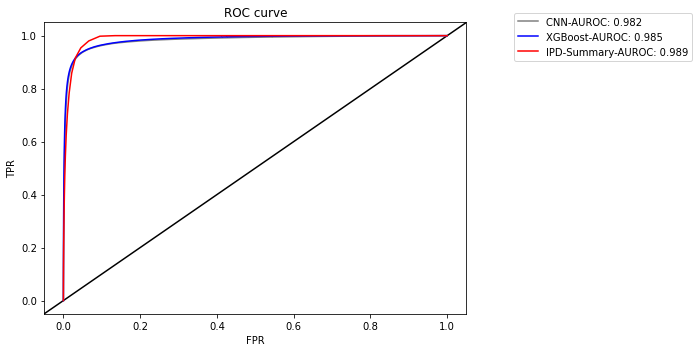

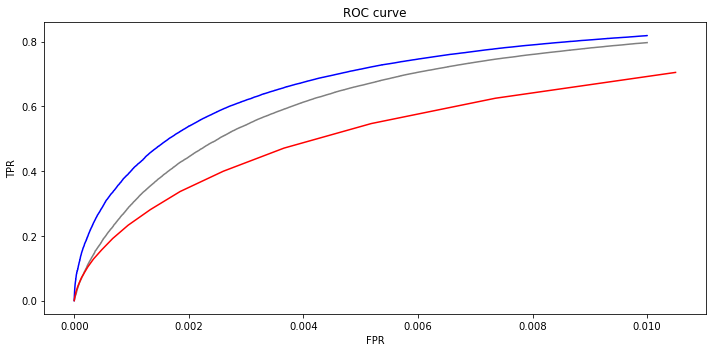

In [17]:
# Plot the ROC curve for IPD-Summary, XGBoost and CNN models
plt.figure(figsize=(10,5))
plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(join.truth, join.pred_cnn, pos_label=1)
print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='gray', label=f"CNN-AUROC: {metrics.auc(fpr, tpr):.03f}")

fpr, tpr, thresholds = metrics.roc_curve(join.truth, join.pred_xgboost, pos_label=1)
print(f"AUC-ROC XGBoost: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='blue', label=f"XGBoost-AUROC: {metrics.auc(fpr, tpr):.03f}")

fpr, tpr, thresholds = metrics.roc_curve(join.truth, join.score, pos_label=1)
print(f"AUC-ROC IPD-Summary: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='red', label=f"IPD-Summary-AUROC: {metrics.auc(fpr, tpr):.03f}")

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_ipd_summary.png")
plt.plot()

# Focus on 1% FPR threshold
plt.figure(figsize=(10,5))
print("cnn_model")
fpr, tpr, thresholds = metrics.roc_curve(np.array(join.truth), np.array(join.pred_cnn), pos_label=1)
idx_fpr = np.where(fpr <= 0.010)[0]
thr_last = thresholds[idx_fpr][-1]

tn, fp, fn, tp = metrics.confusion_matrix(np.array(join.truth), np.array(join.pred_cnn)>=thr_last).ravel()
print(f"CNN model: tn: {tn}, fp: {fp}, fn:{fn}, tp:{tp}")

tpr_1 = tp/(tp+fn)
fpr_1 = fp/(fp+tn)
tnr_1 = tn/(tn+fp)
fnr_1 = fn/(fn+tp)

print(f"CNN model: tpr: {tpr_1}, fpr: {fpr_1}, tnr: {tnr_1}, fnr: {fnr_1}")

print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='gray')

print("xgboost model")
fpr, tpr, thresholds = metrics.roc_curve(np.array(join.truth), join.pred_xgboost, pos_label=1)
idx_fpr = np.where(fpr <= 0.010)[0]

thr_last = thresholds[idx_fpr][-1]

tn, fp, fn, tp = metrics.confusion_matrix(np.array(join.truth), np.array(join.pred_xgboost)>=thr_last).ravel()
print(f"XGBoost: tn: {tn}, fp: {fp}, fn:{fn}, tp:{tp}")

tpr_1 = tp/(tp+fn)
fpr_1 = fp/(fp+tn)
tnr_1 = tn/(tn+fp)
fnr_1 = fn/(fn+tp)

print(f"XGBoost model: tpr: {tpr_1}, fpr: {fpr_1}, tnr: {tnr_1}, fnr: {fnr_1}")

print(f"AUC-ROC XGBoost: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='blue')

print("IPD-summary model")

fpr, tpr, thresholds = metrics.roc_curve(np.array(join.truth), np.array(join.score), pos_label=1)
idx_fpr = np.where(fpr <= 0.015)[0]
thr_last = thresholds[idx_fpr][-1]

tn, fp, fn, tp = metrics.confusion_matrix(np.array(join.truth), np.array(join.score)>=thr_last).ravel()
print(f"IPD-Summary: tn: {tn}, fp: {fp}, fn:{fn}, tp:{tp}")

tpr_1 = tp/(tp+fn)
fpr_1 = fp/(fp+tn)
tnr_1 = tn/(tn+fp)
fnr_1 = fn/(fn+tp)

print(f"IPD-summary model: tpr: {tpr_1}, fpr: {fpr_1}, tnr: {tnr_1}, fnr: {fnr_1}")

print(f"AUC-ROC IPD-Summary: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='red')

#plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_ipd_fdr_1.png")
plt.plot()

AU-PR CNN: 0.8221764499831903
AU-PR XGBoost: 0.8528300907169303
AU-PR IPD-Summary: 0.7721941561759429


[]

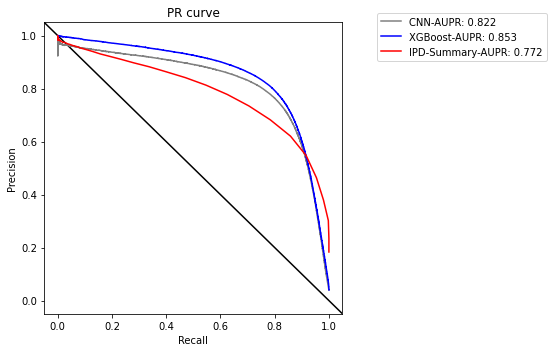

In [18]:
# Plot the PR curve for the IPD-summary, XGBoost and CNN model
plt.figure(figsize=(8,5))
plt.axline([0,0], slope=1, c="white")
plt.axline([0,1], slope=-1, c="black")
precision, recall, thresholds = metrics.precision_recall_curve(join.truth, join.pred_cnn, pos_label=1)
print(f"AU-PR CNN: {metrics.average_precision_score(join.truth, join.pred_cnn)}")
plt.plot(recall, precision, c='gray', label=f"CNN-AUPR: {metrics.average_precision_score(join.truth, join.pred_cnn):.03f}")

precision, recall, thresholds = metrics.precision_recall_curve(join.truth, join.pred_xgboost, pos_label=1)
print(f"AU-PR XGBoost: {metrics.average_precision_score(join.truth, join.pred_xgboost)}")
plt.plot(recall, precision, c='blue', label=f"XGBoost-AUPR: {metrics.average_precision_score(join.truth, join.pred_xgboost):.03f}")

precision, recall, thresholds = metrics.precision_recall_curve(join.truth, join.score, pos_label=1)
print(f"AU-PR IPD-Summary: {metrics.average_precision_score(join.truth, join.score)}")
plt.plot(recall, precision, c='red', label=f"IPD-Summary-AUPR: {metrics.average_precision_score(join.truth, join.score):.03f}")

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/pr_compare_ipd_summary.png")
plt.plot()